<a href="https://colab.research.google.com/github/AndrewNewton13/Learning/blob/main/Transfer_Learning_in_TensorFlow_Part_3_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision Mini Model: Create base model

The goal is to beat the original Food101 paper with 10% of the training data using transfer learning.

The baseline to beat is 50.76% accuracy across 101 classes.

In [ ]:
# Check to see if we're using a GPU
!nvidia-smi

Tue Jul 27 01:42:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Import the helper functions
!wget https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/extras/helper_functions.py

--2021-07-27 01:42:26--  https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/extras/helper_functions.py
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py [following]
--2021-07-27 01:42:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-27 01:42:27 (41.2 MB/s) - ‘helper_

In [ ]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [ ]:
# Download and unzip the data and set up directories
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-07-27 01:42:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   209MB/s    in 6.7s    

2021-07-27 01:42:36 (230 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pad_thai'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/takoyaki'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_onion_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_quesadilla'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chocolate_mousse'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/mussels'.
There are 0 directories and 

In [ ]:
# Set up data inputs
import tensorflow as tf

IMG_SIZE = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # Don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we will create our own output layer)
* Compile our model
* Feature extract for 5 epochs and validate on 15% of test data to save epoch time

In [ ]:
# Create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers  
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2)
], name="data_augmentation_layer")

In [ ]:
# Setup the base model and freeze it's layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs) # augment images, only happens during training phase
x = base_model(x, training=False) # weights will stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(101,activation='softmax',name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
# Check model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(),
             metrics='accuracy')

In [ ]:
# Feature extract 
initial_epochs = 5
history_0 = model.fit(train_data,
                      epochs=initial_epochs,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)),
                      callbacks=[checkpoint_callback,create_tensorboard_callback(dir_name='tensorboard_calbacks',
                                                                                 experiment_name='feature_extraction')])

Saving TensorBoard log files to: tensorboard_calbacks/feature_extraction/20210727-014335
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


237/237 [==============================] - 124s 377ms/step - loss: 3.4783 - accuracy: 0.2471 - val_loss: 2.6367 - val_accuracy: 0.3978
Epoch 2/5
237/237 [==============================] - 79s 331ms/step - loss: 2.3463 - accuracy: 0.4651 - val_loss: 2.2299 - val_accuracy: 0.4513
Epoch 3/5
237/237 [==============================] - 73s 307ms/step - loss: 1.9765 - accuracy: 0.5277 - val_loss: 2.0437 - val_accuracy: 0.4791
Epoch 4/5
237/237 [==============================] - 70s 293ms/step - loss: 1.7648 - accuracy: 0.5765 - val_loss: 1.9808 - val_accuracy: 0.4825
Epoch 5/5
237/237 [==============================] - 66s 277ms/step - loss: 1.6081 - accuracy: 0.6067 - val_loss: 1.9171 - val_accuracy: 0.4928


In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 89s 112ms/step - loss: 1.7255 - accuracy: 0.5491


[1.7255072593688965, 0.5491089224815369]

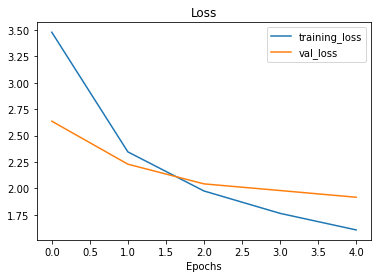

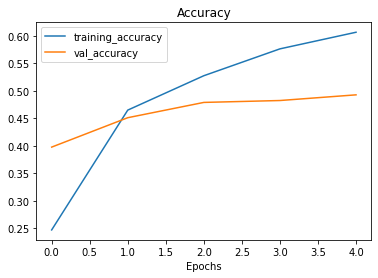

In [ ]:
# Plot the loss curves
plot_loss_curves(history_0)

# Food Vision Mini Model: Fine-Tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Check how many layers are trainable
print(len(base_model.trainable_variables))

6


In [ ]:
# Recompile after unfreezing layers and lower the learning rate
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics='accuracy')

In [ ]:
# See what specific layers are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer, layer.trainable)

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f09604d9a10> False
1 <tensorflow.python.keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f096a538550> False
2 <tensorflow.python.keras.layers.preprocessing.normalization.Normalization object at 0x7f0960547a50> False
3 <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f0960547f10> False
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f09604d4290> False
5 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f096a668e50> False
6 <tensorflow.python.keras.layers.core.Activation object at 0x7f096a663d50> False
7 <tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f096b77e250> False
8 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f096b766910> False
9 <tensorflow.python.keras.layers.core.Activation object at 0x7f096b7933d0> False
10 <tensorflow.python.keras.layers.pooling.Globa

In [ ]:
# Fit the model
total_epochs = initial_epochs + 5
history_fine_1 = model.fit(train_data,
                           epochs=total_epochs,
                           validation_data=test_data,
                           validation_steps=int(0.15 * len(test_data)),
                           initial_epoch=history_0.epoch[-1])

Epoch 5/10
237/237 [==============================] - 66s 251ms/step - loss: 1.3618 - accuracy: 0.6469 - val_loss: 1.8917 - val_accuracy: 0.4997
Epoch 6/10
237/237 [==============================] - 57s 239ms/step - loss: 1.2396 - accuracy: 0.6735 - val_loss: 1.8492 - val_accuracy: 0.5093
Epoch 7/10
237/237 [==============================] - 51s 214ms/step - loss: 1.1521 - accuracy: 0.6924 - val_loss: 1.8322 - val_accuracy: 0.5188
Epoch 8/10
237/237 [==============================] - 54s 228ms/step - loss: 1.0818 - accuracy: 0.7127 - val_loss: 1.9024 - val_accuracy: 0.4987
Epoch 9/10
237/237 [==============================] - 51s 212ms/step - loss: 1.0270 - accuracy: 0.7237 - val_loss: 1.8670 - val_accuracy: 0.5117
Epoch 10/10
237/237 [==============================] - 52s 216ms/step - loss: 0.9772 - accuracy: 0.7410 - val_loss: 1.8640 - val_accuracy: 0.5143


In [ ]:
# Evaluate of the full test dataset 
fine_1_results = model.evaluate(test_data)
fine_1_results

790/790 [==============================] - 88s 111ms/step - loss: 1.6131 - accuracy: 0.5758


[1.6131062507629395, 0.5757623910903931]

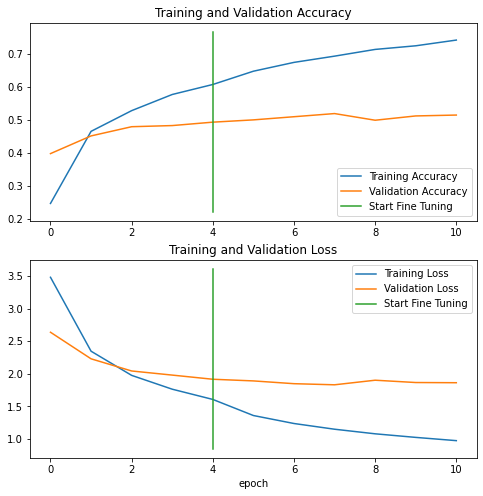

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_0,
                 new_history=history_fine_1,
                 initial_epochs=5)

# Saving and Loading the Models

In [ ]:
# Save our fine-tuned model
# model.save("drive/MyDrive/101_food_classes_10_percent_fine_tuned_1")

In [ ]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/101_food_classes_10_percent_fine_tuned_1") # ignore the warnings

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 91s 114ms/step - loss: 1.6086 - accuracy: 0.5778


[1.6085872650146484, 0.577782154083252]

In [ ]:
fine_1_results

[1.6131062507629395, 0.5757623910903931]

In [ ]:
# Verify the results are close 
import numpy as np
np.isclose(loaded_model_results,fine_1_results)

array([False, False])

# Making Predictions and Getting the Test Labels

Let's see which predictions were most wrong.

In [ ]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-07-27 02:04:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   234MB/s    in 0.2s    

2021-07-27 02:04:12 (234 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load the pre-trained model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 92s 115ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

In [ ]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 64s 80ms/step


In [ ]:
# How many predictions are there? 
len(pred_probs)

25250

In [ ]:
# What's the shape of our predictions
pred_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 predictions look like
pred_probs[:10]

array([[5.95420077e-02, 3.57419503e-06, 4.13768589e-02, ...,
        1.41386813e-09, 8.35307583e-05, 3.08974274e-03],
       [9.64016676e-01, 1.37532707e-09, 8.47805641e-04, ...,
        5.42872003e-05, 7.83623513e-12, 9.84663906e-10],
       [9.59258676e-01, 3.25335823e-05, 1.48669467e-03, ...,
        7.18913384e-07, 5.43973158e-07, 4.02759651e-05],
       ...,
       [4.73132670e-01, 1.29312355e-07, 1.48055656e-03, ...,
        5.97501639e-04, 6.69690999e-05, 2.34693434e-05],
       [4.45719399e-02, 4.72655188e-07, 1.22585356e-01, ...,
        6.34984963e-06, 7.53185031e-06, 3.67787597e-03],
       [7.24390090e-01, 1.92497107e-09, 5.23109738e-05, ...,
        1.22913450e-03, 1.57926350e-09, 9.63957209e-05]], dtype=float32)

In [ ]:
# What does the first prediction probability array look like?
pred_probs[0], len(pred_probs[0]), sum(pred_probs[0])

(array([5.9542008e-02, 3.5741950e-06, 4.1376859e-02, 1.0660556e-09,
        8.1613978e-09, 8.6639664e-09, 8.0926822e-07, 8.5652499e-07,
        1.9859017e-05, 8.0977776e-07, 3.1727747e-09, 9.8673661e-07,
        2.8532164e-04, 7.8049051e-10, 7.4230169e-04, 3.8916416e-05,
        6.4740193e-06, 2.4977280e-06, 3.7891099e-05, 2.0678388e-07,
        1.5538422e-05, 8.1506943e-07, 2.6230446e-06, 2.0010630e-07,
        8.3827456e-07, 5.4215989e-06, 3.7390860e-06, 1.3150533e-08,
        2.7761406e-03, 2.8051838e-05, 6.8562162e-10, 2.5574835e-05,
        1.6688865e-04, 7.6407297e-10, 4.0452729e-04, 1.3150634e-08,
        1.7957379e-06, 1.4448218e-06, 2.3062859e-02, 8.2466784e-07,
        8.5365781e-07, 1.7138614e-06, 7.0525107e-06, 1.8402169e-08,
        2.8553407e-07, 7.9483234e-06, 2.0681514e-06, 1.8525066e-07,
        3.3619774e-08, 3.1522498e-04, 1.0410913e-05, 8.5448539e-07,
        8.4741873e-01, 1.0555415e-05, 4.4094671e-07, 3.7404148e-05,
        3.5306231e-05, 3.2489133e-05, 6.7314817e

In [ ]:
# We get one prediction probability per class (we have 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9542008e-02 3.5741950e-06 4.1376859e-02 1.0660556e-09 8.1613978e-09
 8.6639664e-09 8.0926822e-07 8.5652499e-07 1.9859017e-05 8.0977776e-07
 3.1727747e-09 9.8673661e-07 2.8532164e-04 7.8049051e-10 7.4230169e-04
 3.8916416e-05 6.4740193e-06 2.4977280e-06 3.7891099e-05 2.0678388e-07
 1.5538422e-05 8.1506943e-07 2.6230446e-06 2.0010630e-07 8.3827456e-07
 5.4215989e-06 3.7390860e-06 1.3150533e-08 2.7761406e-03 2.8051838e-05
 6.8562162e-10 2.5574835e-05 1.6688865e-04 7.6407297e-10 4.0452729e-04
 1.3150634e-08 1.7957379e-06 1.4448218e-06 2.3062859e-02 8.2466784e-07
 8.5365781e-07 1.7138614e-06 7.0525107e-06 1.8402169e-08 2.8553407e-07
 7.9483234e-06 2.0681514e-06 1.8525066e-07 3.3619774e-08 3.1522498e-04
 1.0410913e-05 8.5448539e-07 8.4741873e-01 1.0555415e-05 4.4094671e-07
 3.7404148e-05 3.5306231e-05 3.2489133e-05 6.7314817e-05 1.2852616e-08
 2.6219660e-10 1.0318080e-05 8.5744046e-05 1.

In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# How many pred classes do we have?
len(pred_classes), pred_classes.shape

(25250, (25250,))

In [ ]:
test_data # Need to unbatch the dataset 

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # Currently the test labels are one-hot encoded so we need where 1 occurs

# Look at the first 10
y_labels[:10] # these are all 0 because they belong to the apple pie class (which is the first class at index 0)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_labels are there?
len(y_labels)

25250

# Evaluating the Model

In [ ]:
# Recall our accuracy from earlier
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [ ]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels,pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
# Does this metric come close to our model's evaluate results?
import numpy as np
np.isclose(results_downloaded_model[1],sklearn_accuracy)

True

In [ ]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Let's get visualize and make a confusion matrix
from helper_functions import make_confusion_matrix

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

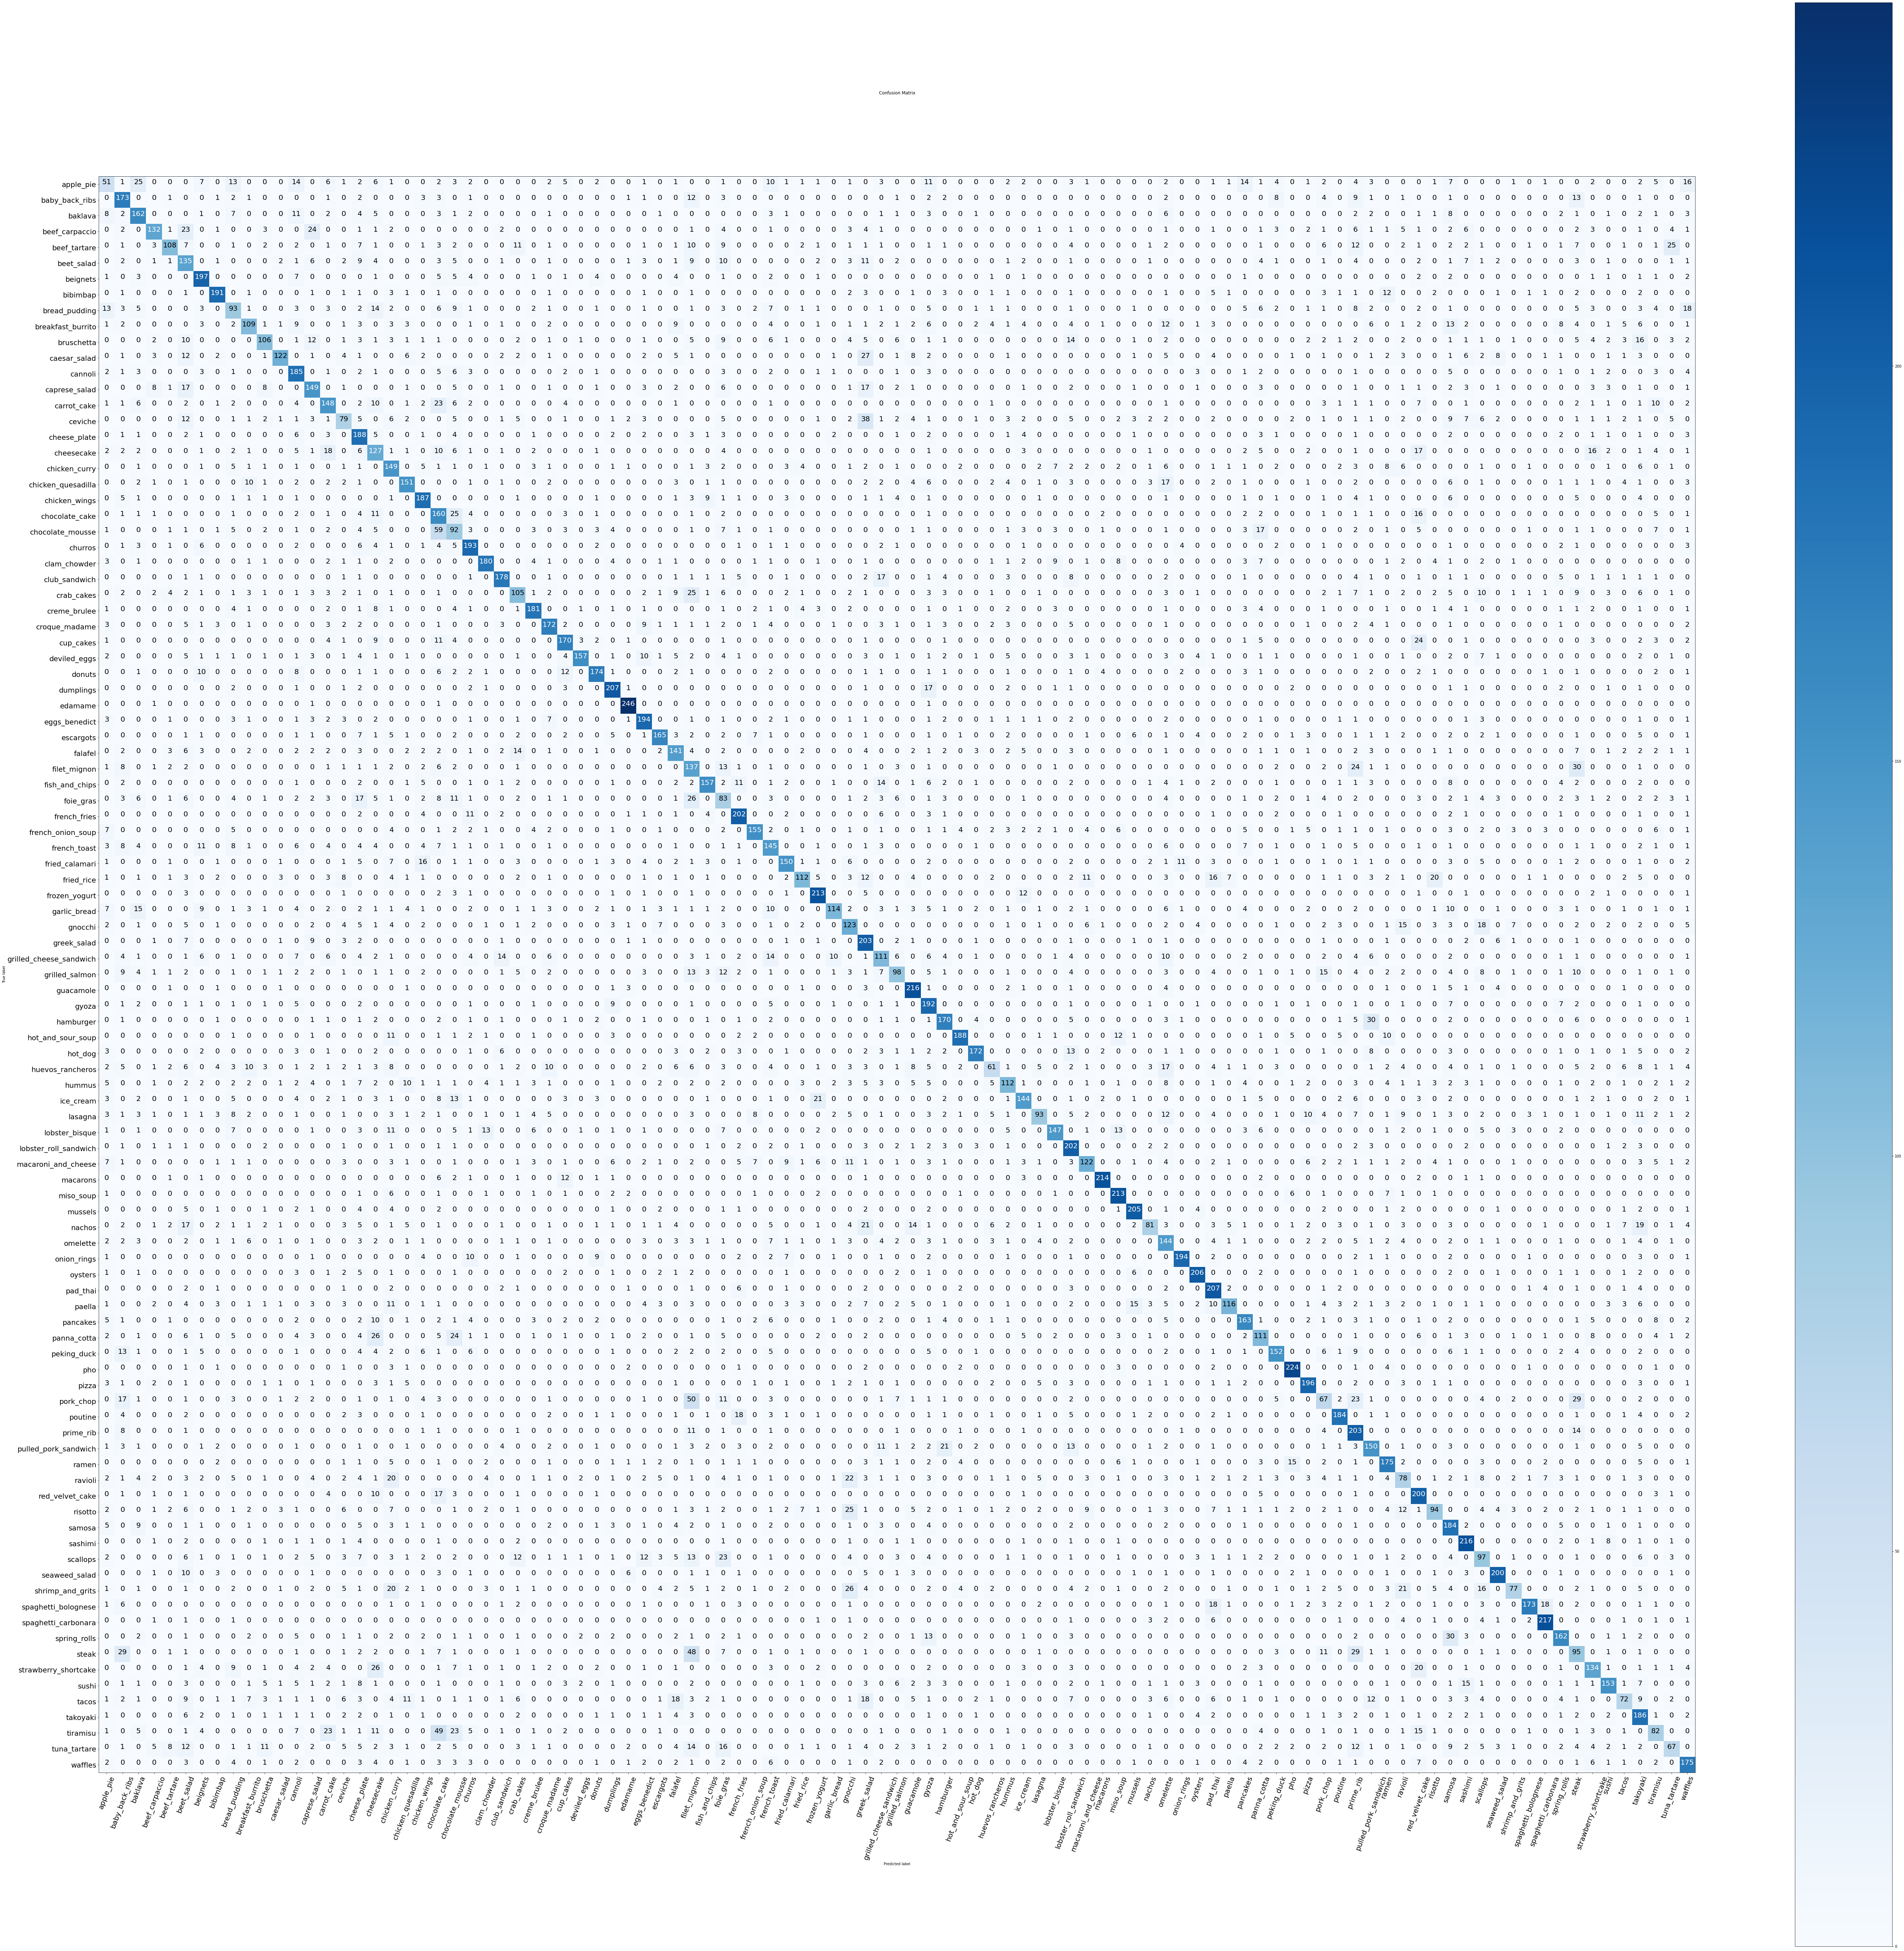

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

In [ ]:
# Time for a classification report
from sklearn.metrics import classification_report

print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels,pred_classes,output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [ ]:
class_names[70]

'pad_thai'

In [ ]:
# Let's plot all of our classes F1-scores
# Create empty dictionary
class_f1_scores = {}

# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else: 
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores 

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [ ]:
# What does our dataframe look like?
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

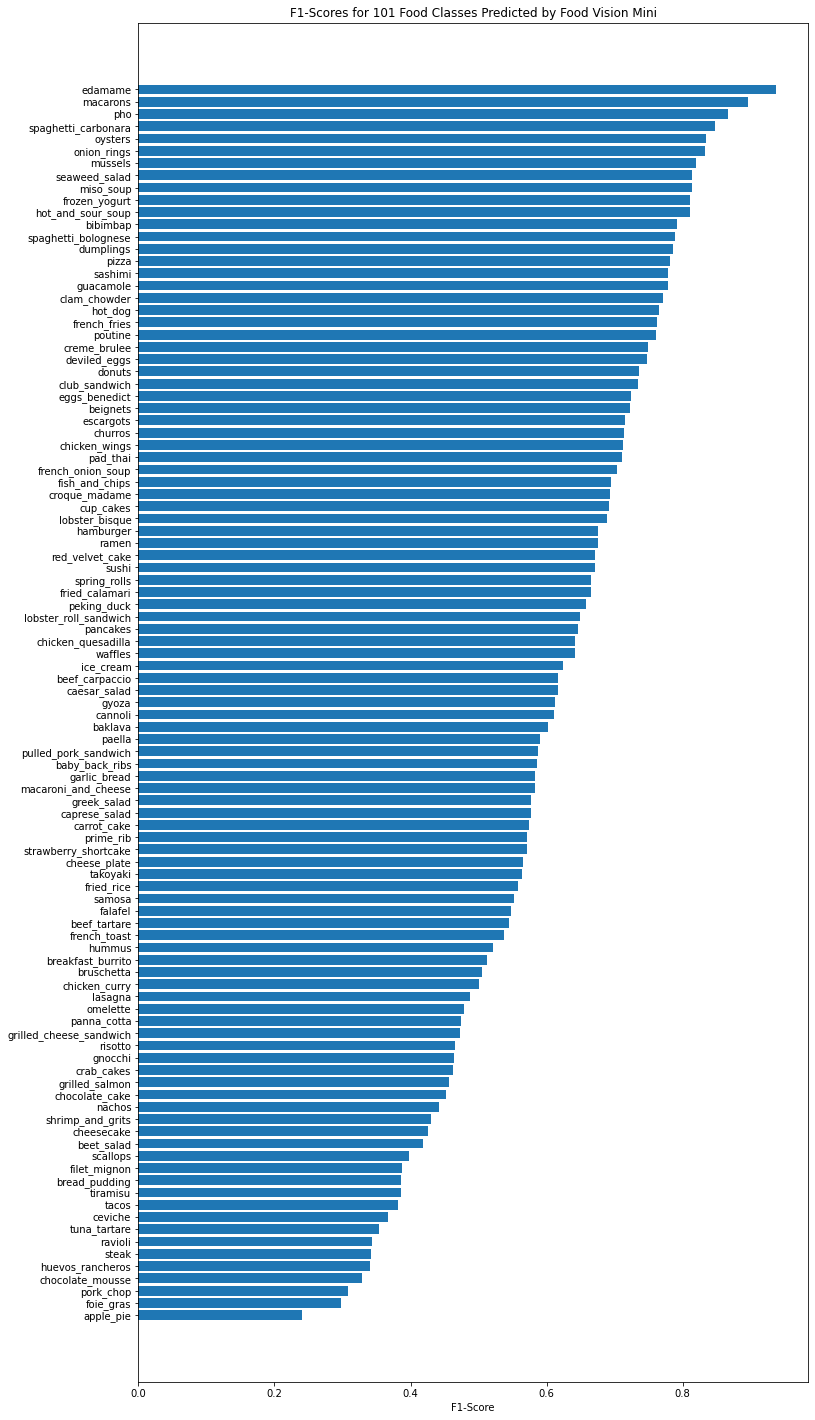

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-Score")
ax.set_title("F1-Scores for 101 Food Classes Predicted by Food Vision Mini")
ax.invert_yaxis()



# Visualizing Predictions on Test Images

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename,img_shape=224,scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specified 
  shape (img_shape, img_shape, color_channels=3)
  
  Args: 
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shapes (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(images=img,size=(img_shape,img_shape))

  # Scale? Yes/no
  if scale: 
    # rescale the image 
    return img/255.
  else: 
    return img 

The next steps:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability, and truth label

101_food_classes_10_percent/test/ravioli/1093582.jpg
(224, 224, 3)
101_food_classes_10_percent/test/caesar_salad/3261516.jpg
(224, 224, 3)
101_food_classes_10_percent/test/hamburger/137432.jpg
(224, 224, 3)


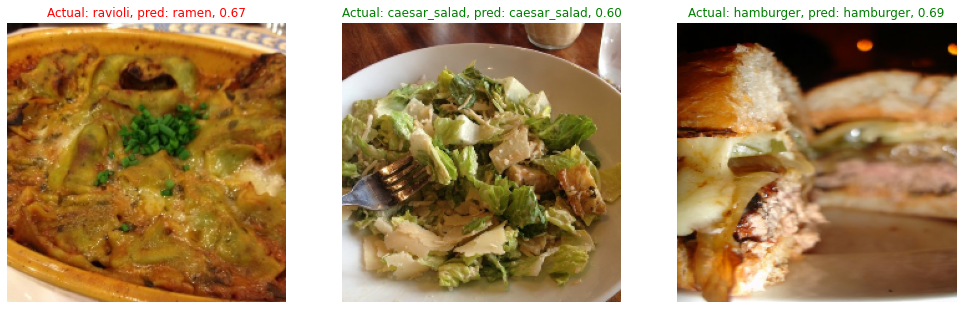

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  # Choose a random image(s) from random class(es)
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  print(filepath)

  # Load the image and make predictions
  img = load_and_prep_image(filepath,img_shape=224,scale=False)
  print(img.shape)
  img_expanded = tf.expand_dims(img,axis=0)
  pred_prob = model.predict(img_expanded) # get prediction probabilities array 
  pred_class = class_names[pred_prob.argmax()] # get highest probability index
  # print(pred_prob)
  # print(pred_class)
  
  # Plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255)
  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"Actual: {class_name}, pred: {pred_class}, {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)

# Finding the Most Wrong Predictions

The steps:
1. Get all of the image file paths in the test dataset using 
list_files() method
2. Create a pandas DataFrame of the image filepaths, ground truth
labels, predicted classes (from our model), max prediction 
probabilities, prediction class names, ground truth class names
3. Use our DataFrame to find all the wrong predictions (where
the ground truth label doesn't match the prediction)
4. Sort the DataFrame based on wrong predictions (have the highest 
prediction probability predictions at the top)
5. Visualize the images with the highest prediction
probabilities but have the wrong prediction

In [ ]:
# 1. Get all of the image files path in the test dataset 
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2. Create a DataFrame of differenet parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # softmax output activation result
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  ...      y_pred_classname
0      b'/content/101_food_classes_10_percent/test/ap...  ...                 gyoza
1      b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
2      b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
3      b'/content/101_food_classes_10_percent/test/ap...  ...  pulled_pork_sandwich
4      b'/content/101_food_classes_10_percent/test/ap...  ...             prime_rib
...                                                  ...  ...                   ...
25245  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles
25246  b'/content/101_food_classes_10_percent/test/wa...  ...          cheese_plate
25247  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles
25248  b'/content/101_food_classes_10_percent/test/wa...  ...  strawberry_shortcake
25249  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles

[25250 rows x 6 columns]

In [ ]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  ...  pred_correct
0  b'/content/101_food_classes_10_percent/test/ap...  ...         False
1  b'/content/101_food_classes_10_percent/test/ap...  ...          True
2  b'/content/101_food_classes_10_percent/test/ap...  ...          True
3  b'/content/101_food_classes_10_percent/test/ap...  ...         False
4  b'/content/101_food_classes_10_percent/test/ap...  ...         False

[5 rows x 7 columns]

In [ ]:
# 4. Sort the DataFrame to have hte most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf",ascending=False)[:100]
top_100_wrong.head(20)

img_path  ...  pred_correct
21810  b'/content/101_food_classes_10_percent/test/sc...  ...         False
231    b'/content/101_food_classes_10_percent/test/ap...  ...         False
15359  b'/content/101_food_classes_10_percent/test/lo...  ...         False
23539  b'/content/101_food_classes_10_percent/test/st...  ...         False
21400  b'/content/101_food_classes_10_percent/test/sa...  ...         False
24540  b'/content/101_food_classes_10_percent/test/ti...  ...         False
2511   b'/content/101_food_classes_10_percent/test/br...  ...         False
5574   b'/content/101_food_classes_10_percent/test/ch...  ...         False
17855  b'/content/101_food_classes_10_percent/test/pa...  ...         False
23797  b'/content/101_food_classes_10_percent/test/su...  ...         False
18001  b'/content/101_food_classes_10_percent/test/pa...  ...         False
11642  b'/content/101_food_classes_10_percent/test/ga...  ...         False
10847  b'/content/101_food_classes_10_percent/test/fr...  ...         False
23631  b'/content/101_food_classes_10_percent/test/st...  ...         False
1155   b'/content/101_food_classes_10_percent/test/be...  ...         False
10854  b'/content/101_food_classes_10_percent/test/fr...  ...         False
23904  b'/content/101_food_classes_10_percent/test/su...  ...         False
7316   b'/content/101_food_classes_10_percent/test/cu...  ...         False
13144  b'/content/101_food_classes_10_percent/test/gy...  ...         False
10880  b'/content/101_food_classes_10_percent/test/fr...  ...         False

[20 rows x 7 columns]

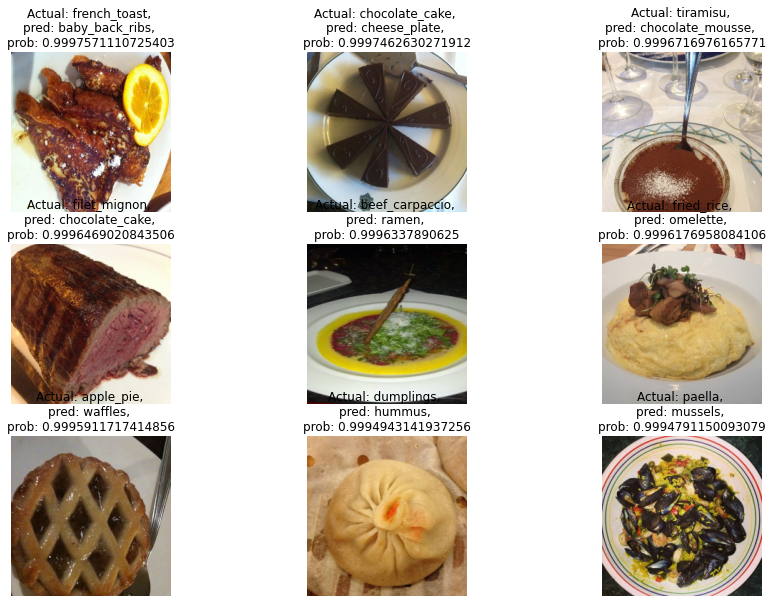

In [ ]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability 
images_to_view = 9
start_index = 20
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[1],scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"Actual: {y_true_classname}, \npred: {y_pred_classname}, \nprob: {pred_prob}")
  plt.axis(False)

In [ ]:
# Test out the model on our own custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")

--2021-07-27 02:45:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2021-07-27 02:45:01 (111 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



In [ ]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/sushi.jpeg']

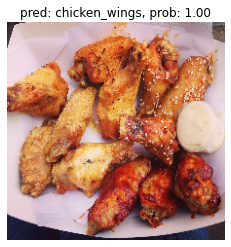

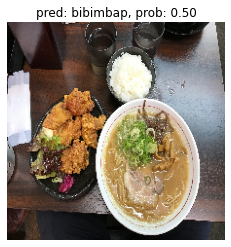

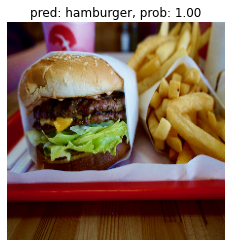

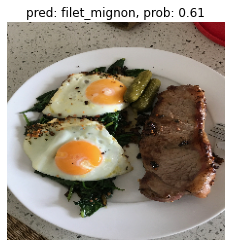

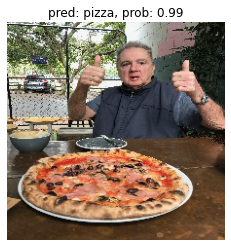

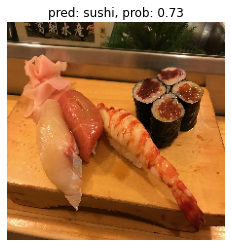

In [ ]:
# Make predictions and plot on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()] # get index with highest prediction probability
  # Plot the appropiate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

# Exercises
1. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?
2. Recreate the first model (the feature extraction model) with mixed_precision turned on.

# Build a Base Model and Train for 10 Epochs

In [ ]:
# Create train and test directories
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [ ]:
# Create train and test data
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=(224,224))
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=(224,224))

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
# Setup the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

In [ ]:
# Setup the inputs
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

In [ ]:
# Create data aug layer
data_aug = Sequential([
                       preprocessing.RandomFlip("horizontal"),
                       preprocessing.RandomHeight(0.2),
                       preprocessing.RandomWidth(0.2),
                       preprocessing.RandomRotation(0.2),
                       preprocessing.RandomZoom(0.2)
])
x = data_aug(inputs)

In [ ]:
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(101,activation='softmax',name='output_layer')(x)

In [ ]:
model = tf.keras.Model(inputs,outputs)

In [ ]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics='accuracy')

In [ ]:
# Fit the model
base_model_history_10_epochs = model.fit(train_data,
                                         epochs=10,
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         callbacks=tf.keras.callbacks.ModelCheckpoint(filepath="base_model_10_epochs.ckpt",
                                                                                      save_weights_only=True))

Epoch 1/10
237/237 [==============================] - 56s 213ms/step - loss: 3.4922 - accuracy: 0.2532 - val_loss: 2.4626 - val_accuracy: 0.4394
Epoch 2/10
237/237 [==============================] - 50s 210ms/step - loss: 2.3846 - accuracy: 0.4524 - val_loss: 2.0182 - val_accuracy: 0.5026
Epoch 3/10
237/237 [==============================] - 48s 201ms/step - loss: 2.0076 - accuracy: 0.5241 - val_loss: 1.8664 - val_accuracy: 0.5228
Epoch 4/10
237/237 [==============================] - 47s 199ms/step - loss: 1.7958 - accuracy: 0.5634 - val_loss: 1.7713 - val_accuracy: 0.5421
Epoch 5/10
237/237 [==============================] - 49s 206ms/step - loss: 1.6414 - accuracy: 0.6007 - val_loss: 1.7310 - val_accuracy: 0.5445
Epoch 6/10
237/237 [==============================] - 46s 195ms/step - loss: 1.5320 - accuracy: 0.6199 - val_loss: 1.6863 - val_accuracy: 0.5585
Epoch 7/10
237/237 [==============================] - 46s 194ms/step - loss: 1.4160 - accuracy: 0.6558 - val_loss: 1.6598 - val_ac

In [ ]:
base_model_10_epochs_results = model.evaluate(test_data)

790/790 [==============================] - 89s 112ms/step - loss: 1.6338 - accuracy: 0.5674


# Build a Base Model and Train for 5 Epochs

In [ ]:
# Create train and test directories and data
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=(224,224))
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=(224,224))

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
# Build the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

In [ ]:
# Setup the inputs
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

In [ ]:
# Create data augmentation layer
data_aug = Sequential([
                       preprocessing.RandomFlip("horizontal"),
                       preprocessing.RandomHeight(0.2),
                       preprocessing.RandomWidth(0.2),
                       preprocessing.RandomRotation(0.2),
                       preprocessing.RandomZoom(0.2)
])
x = data_aug(inputs)

In [ ]:
x = base_model(x, training=False)

In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(101,activation='softmax',name='output_layer')(x)

In [ ]:
model_5_epochs = tf.keras.Model(inputs,outputs)

In [ ]:
# Compile the model
model_5_epochs.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics='accuracy')

In [ ]:
# Fit the model
base_model_history_5_epochs = model_5_epochs.fit(train_data,
                                                 epochs=5,
                                                 validation_data=test_data,
                                                 validation_steps=int(0.15 * len(test_data)),
                                                 callbacks=tf.keras.callbacks.ModelCheckpoint("base_model_5_epochs_checkpoint.ckpt",
                                                                                              save_weights_only=True))

Epoch 1/5
237/237 [==============================] - 59s 188ms/step - loss: 3.4988 - accuracy: 0.2387 - val_loss: 2.4839 - val_accuracy: 0.4404
Epoch 2/5
237/237 [==============================] - 45s 187ms/step - loss: 2.3803 - accuracy: 0.4458 - val_loss: 2.0413 - val_accuracy: 0.5040
Epoch 3/5
237/237 [==============================] - 45s 188ms/step - loss: 2.0098 - accuracy: 0.5229 - val_loss: 1.8745 - val_accuracy: 0.5257
Epoch 4/5
237/237 [==============================] - 43s 181ms/step - loss: 1.7890 - accuracy: 0.5662 - val_loss: 1.7812 - val_accuracy: 0.5355
Epoch 5/5
237/237 [==============================] - 44s 184ms/step - loss: 1.6450 - accuracy: 0.5958 - val_loss: 1.7261 - val_accuracy: 0.5453


In [ ]:
base_model_5_epochs_results = model_5_epochs.evaluate(test_data)

790/790 [==============================] - 89s 113ms/step - loss: 1.7205 - accuracy: 0.5520


# Fine-Tuning the Model Trained on 5 Epochs

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5 
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Check how many layers are trainable
print(len(base_model.trainable_variables))

6


In [ ]:
# Recompile the model and adjust the learning rate
model_5_epochs.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       metrics='accuracy')

In [ ]:
# Fit the model
fine_tune_history_5_epochs = model_5_epochs.fit(train_data,
                                                epochs=10,
                                                validation_data=test_data,
                                                validation_steps=int(0.15 * len(test_data)),
                                                initial_epoch=base_model_history_5_epochs.epoch[-1])

Epoch 5/10
237/237 [==============================] - 51s 193ms/step - loss: 1.4067 - accuracy: 0.6355 - val_loss: 1.6435 - val_accuracy: 0.5638
Epoch 6/10
237/237 [==============================] - 44s 184ms/step - loss: 1.2927 - accuracy: 0.6603 - val_loss: 1.6373 - val_accuracy: 0.5599
Epoch 7/10
237/237 [==============================] - 43s 181ms/step - loss: 1.2121 - accuracy: 0.6815 - val_loss: 1.6203 - val_accuracy: 0.5620
Epoch 8/10
237/237 [==============================] - 43s 182ms/step - loss: 1.1289 - accuracy: 0.7032 - val_loss: 1.6082 - val_accuracy: 0.5628
Epoch 9/10
237/237 [==============================] - 44s 184ms/step - loss: 1.0771 - accuracy: 0.7174 - val_loss: 1.6021 - val_accuracy: 0.5654
Epoch 10/10
237/237 [==============================] - 43s 179ms/step - loss: 1.0173 - accuracy: 0.7291 - val_loss: 1.5946 - val_accuracy: 0.5702


In [ ]:
fine_tune_5_epochs_results = model_5_epochs.evaluate(test_data)

790/790 [==============================] - 90s 113ms/step - loss: 1.6029 - accuracy: 0.5771


In [ ]:
# Compare the results
base_model_10_epochs_results

[1.6337611675262451, 0.5674059391021729]

The fine-tuned performed at 57.7% while the base model trained on 10 epochs performed at 56.7%.

# Recreate the Feature Extraction Model with Mixed Precision

In [ ]:
import tensorflow as tf

In [ ]:
# Import the helper functions
!wget https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/extras/helper_functions.py
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

--2021-07-27 09:38:39--  https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/extras/helper_functions.py
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py [following]
--2021-07-27 09:38:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-27 09:38:40 (82.6 MB/s) - ‘helper_func

In [ ]:
# Downgrade tensorflow version (on your colab notebook) 
!pip install tensorflow==2.4.1 

     |████████████████████████████████| 394.3 MB 12 kB/s 
     |████████████████████████████████| 2.9 MB 45.9 MB/s 
     |████████████████████████████████| 3.8 MB 36.0 MB/s 
     |████████████████████████████████| 462 kB 42.9 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.

In [ ]:
# Check if TensorFlow 2.4.1 is active 
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
# Download and unzip the data and set up directories
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2021-07-27 09:38:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.208, 172.217.12.240, 172.217.15.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.9.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   140MB/s    in 13s     

2021-07-27 09:38:58 (122 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [ ]:
# Setup mixed precision and set the policy
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
# Create train and test directories and data
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=(224,224))
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=(224,224))

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
# Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False,)
base_model.trainable = False

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
# Setup the inputs
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

In [ ]:
from tensorflow.keras import layers  
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
# set up data aug
data_aug = tf.keras.Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                preprocessing.RandomRotation(0.2)
])
x = data_aug(inputs)
x = base_model(x,training=False)

In [ ]:
# Create pooling and output layer
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(101,activation='softmax',name='output_layer')(x)

In [ ]:
# Create the model
model = tf.keras.Model(inputs,outputs)

In [ ]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics='accuracy')

In [ ]:
# Fit the model
mixed_precision_model = model.fit(train_data,
                                  epochs=5,
                                  validation_data=test_data,
                                  validation_steps=int(0.15 * len(test_data)))

Epoch 1/5
237/237 [==============================] - 105s 283ms/step - loss: 3.9816 - accuracy: 0.1475 - val_loss: 2.4165 - val_accuracy: 0.4544
Epoch 2/5
237/237 [==============================] - 49s 202ms/step - loss: 2.4348 - accuracy: 0.4516 - val_loss: 2.0042 - val_accuracy: 0.5082
Epoch 3/5
237/237 [==============================] - 47s 198ms/step - loss: 2.0260 - accuracy: 0.5240 - val_loss: 1.8403 - val_accuracy: 0.5278
Epoch 4/5
237/237 [==============================] - 47s 197ms/step - loss: 1.7957 - accuracy: 0.5675 - val_loss: 1.7487 - val_accuracy: 0.5474
Epoch 5/5
237/237 [==============================] - 47s 195ms/step - loss: 1.6631 - accuracy: 0.5892 - val_loss: 1.6932 - val_accuracy: 0.5599
